In [1]:
!pip install plotly kagglehub scipy

Defaulting to user installation because normal site-packages is not writeable
  Using cached scipy-1.16.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   --------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
print("="*80)
print("LOADING DATASET")
print("="*80)
df = pd.read_csv('cleaned_aqi_data.csv')

# Display basic information
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head(10))
print(f"\nData Types:")
print(df.dtypes)
print(f"\nMissing Values:")
print(df.isnull().sum())
print(f"\nBasic Statistics:")
print(df.describe())

# Data preprocessing
# Convert date column to datetime if exists
date_columns = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower() or 'year' in col.lower()]
print(f"\nDate columns found: {date_columns}")

if date_columns:
    try:
        df[date_columns[0]] = pd.to_datetime(df[date_columns[0]], errors='coerce')
        df['Year'] = df[date_columns[0]].dt.year
        df['Month'] = df[date_columns[0]].dt.month
        df['Month_Name'] = df[date_columns[0]].dt.month_name()
        print(f"✓ Date parsing successful")
    except:
        print("! Date parsing failed, checking for separate year column")

# Check if Year column already exists
if 'Year' not in df.columns:
    year_cols = [col for col in df.columns if 'year' in col.lower()]
    if year_cols:
        df['Year'] = df[year_cols[0]]

# Identify numeric pollutant columns
pollutant_cols = [col for col in df.columns if any(p in col.upper() for p in ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'AQI', 'NH3'])]
print(f"\nPollutant columns identified: {pollutant_cols}")

# Identify location columns
location_cols = [col for col in df.columns if any(loc in col.lower() for loc in ['city', 'state', 'location', 'station'])]
print(f"Location columns found: {location_cols}")

# Set style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

LOADING DATASET

Dataset Shape: (18265, 21)

Columns: ['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket', 'Year', 'Month', 'Day', 'Season', 'Health_Category']

First few rows:
        City        Date  PM2.5   PM10     NO    NO2    NOx   NH3    CO   SO2  \
0      Delhi  2015-01-01  153.3  241.7  182.9   33.0   81.3  38.5  1.87  64.5   
1     Mumbai  2015-01-01   70.5  312.7  195.0   42.0  122.5  31.5  7.22  83.8   
2    Chennai  2015-01-01  174.1  275.4   56.2   68.8  230.9  28.5  8.56  60.8   
3    Kolkata  2015-01-01  477.2  543.9   14.1   76.4  225.9  45.6  2.41  42.1   
4  Bangalore  2015-01-01  171.6  117.7  123.3   12.4   61.9  49.7  1.26  79.7   
5      Delhi  2015-01-02  344.2  173.2  179.8  128.4  156.1  15.6  6.28   7.5   
6     Mumbai  2015-01-02   59.2  335.7  182.1  143.8  207.3  44.8  5.81   6.4   
7    Chennai  2015-01-02  418.9  573.8   23.8   17.5   43.0  22.5  4.49   9.5   
8    Kolkata  

# Data Pre-Processing

In [11]:
# Convert date column to datetime if exists
date_columns = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
if date_columns:
    df[date_columns[0]] = pd.to_datetime(df[date_columns[0]], errors='coerce')
    df['Year'] = df[date_columns[0]].dt.year
    df['Month'] = df[date_columns[0]].dt.month
    df['Month_Name'] = df[date_columns[0]].dt.month_name()

# Identify numeric pollutant columns
pollutant_cols = [col for col in df.columns if any(p in col.upper() for p in ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'AQI', 'NH3'])]
print(f"\nPollutant columns identified: {pollutant_cols}")

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)



Pollutant columns identified: ['PM2.5', 'PM10', 'NO2', 'NH3', 'CO', 'SO2', 'O3', 'AQI', 'AQI_Bucket']


## 1. TEMPORAL ANALYSIS - TIME SERIES OF POLLUTANTS

In [12]:
print("\n" + "="*80)
print("Creating Visualization 1: Temporal Trends")
print("="*80)

if date_columns and pollutant_cols:
    fig = make_subplots(
        rows=len(pollutant_cols[:6]), cols=1,
        subplot_titles=[f'{col} Over Time' for col in pollutant_cols[:6]],
        vertical_spacing=0.05
    )
    
    for idx, col in enumerate(pollutant_cols[:6], 1):
        if col in df.columns:
            df_temp = df.groupby(date_columns[0])[col].mean().reset_index()
            fig.add_trace(
                go.Scatter(x=df_temp[date_columns[0]], y=df_temp[col], 
                          mode='lines', name=col, line=dict(width=2)),
                row=idx, col=1
            )
    
    fig.update_layout(height=1800, title_text="Air Quality Pollutants - Temporal Trends (2015-2024)", showlegend=False)
    fig.write_html('temporal_trends.html')
    print("✓ Saved: temporal_trends.html")



Creating Visualization 1: Temporal Trends
✓ Saved: temporal_trends.html


## 2. POLLUTANT DISTRIBUTION - BOX PLOTS



Creating Visualization 2: Pollutant Distributions
✓ Saved: pollutant_distributions.png


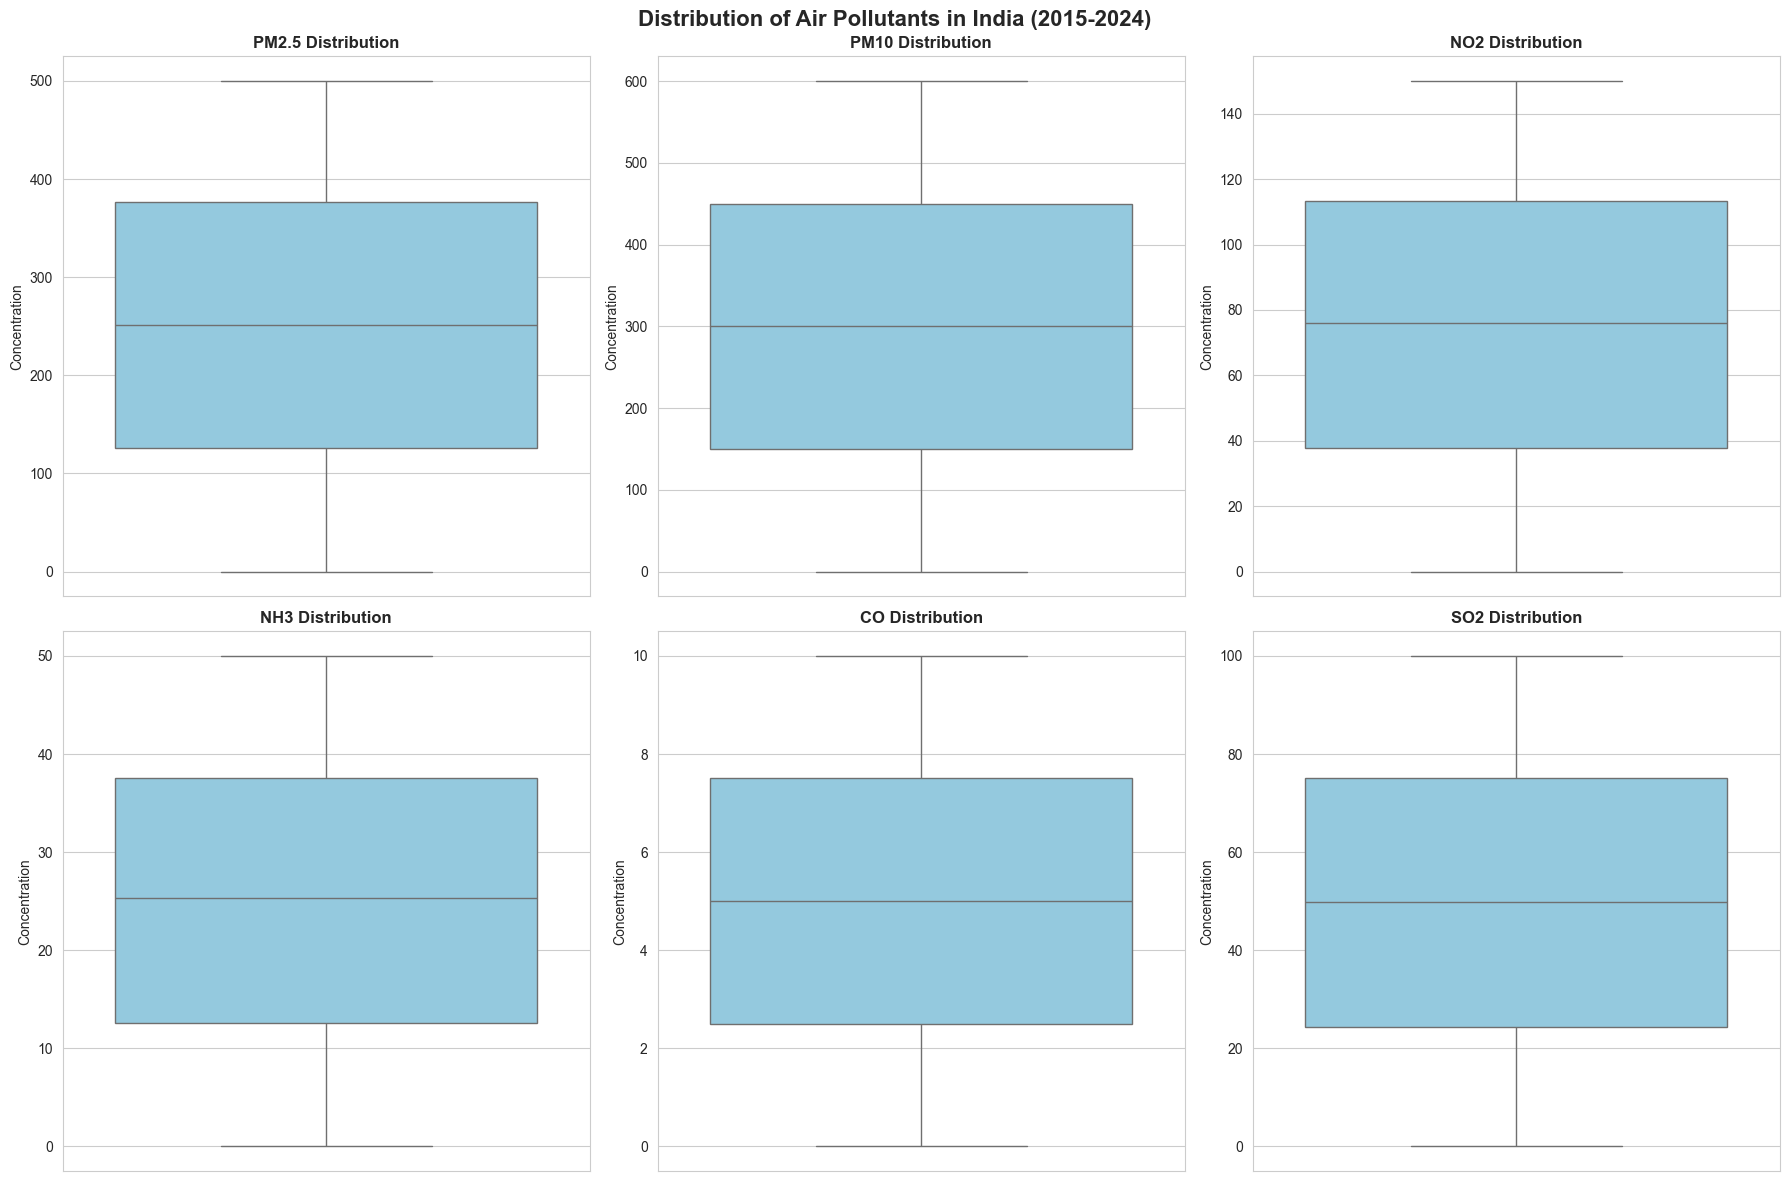

In [14]:
print("\n" + "="*80)
print("Creating Visualization 2: Pollutant Distributions")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution of Air Pollutants in India (2015-2024)', fontsize=16, fontweight='bold')

for idx, col in enumerate(pollutant_cols[:6]):
    if col in df.columns:
        row, col_pos = idx // 3, idx % 3
        sns.boxplot(data=df, y=col, ax=axes[row, col_pos], color='skyblue')
        axes[row, col_pos].set_title(f'{col} Distribution', fontweight='bold')
        axes[row, col_pos].set_ylabel('Concentration')
        
plt.tight_layout()
plt.savefig('pollutant_distributions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: pollutant_distributions.png")
plt.show()


## 3. YEARLY TRENDS - LINE PLOT

In [15]:
print("\n" + "="*80)
print("Creating Visualization 3: Yearly Average Trends")
print("="*80)

if 'Year' in df.columns and pollutant_cols:
    yearly_data = df.groupby('Year')[pollutant_cols[:4]].mean().reset_index()
    
    fig = go.Figure()
    for col in pollutant_cols[:4]:
        if col in yearly_data.columns:
            fig.add_trace(go.Scatter(
                x=yearly_data['Year'], 
                y=yearly_data[col],
                mode='lines+markers',
                name=col,
                line=dict(width=3),
                marker=dict(size=10)
            ))
    
    fig.update_layout(
        title='Average Yearly Trends of Major Pollutants',
        xaxis_title='Year',
        yaxis_title='Average Concentration',
        hovermode='x unified',
        template='plotly_white',
        height=600
    )
    fig.write_html('yearly_trends.html')
    print("✓ Saved: yearly_trends.html")



Creating Visualization 3: Yearly Average Trends
✓ Saved: yearly_trends.html


## 4. SEASONAL PATTERNS - MONTHLY HEATMAP


Creating Visualization 4: Seasonal Patterns
✓ Saved: seasonal_patterns.png


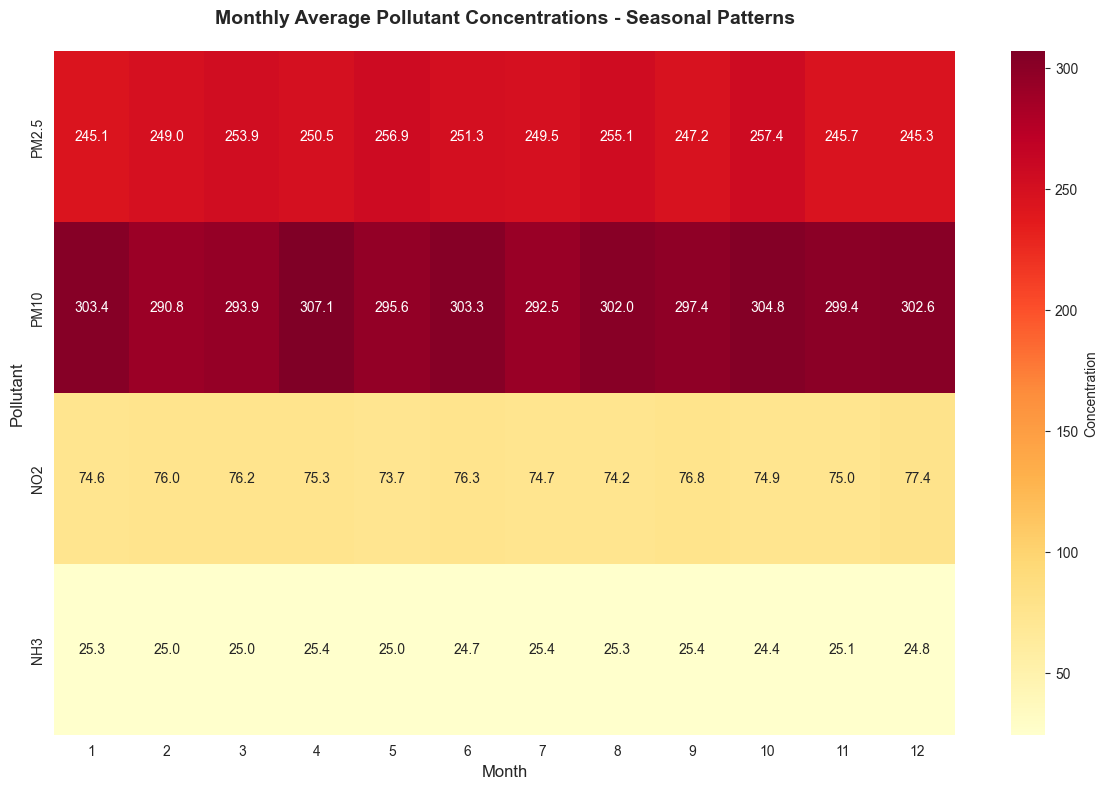

In [16]:
print("\n" + "="*80)
print("Creating Visualization 4: Seasonal Patterns")
print("="*80)

if 'Month' in df.columns and pollutant_cols:
    monthly_avg = df.groupby('Month')[pollutant_cols[:4]].mean()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(monthly_avg.T, annot=True, fmt='.1f', cmap='YlOrRd', 
                cbar_kws={'label': 'Concentration'})
    plt.title('Monthly Average Pollutant Concentrations - Seasonal Patterns', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Pollutant', fontsize=12)
    plt.tight_layout()
    plt.savefig('seasonal_patterns.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: seasonal_patterns.png")
    plt.show()

## 5. GEOGRAPHIC ANALYSIS (if city/state column exists)

In [18]:
print("\n" + "="*80)
print("Creating Visualization 6: Geographic Analysis")
print("="*80)

location_cols = [col for col in df.columns if any(loc in col.lower() for loc in ['city', 'state', 'location', 'station'])]

if location_cols and pollutant_cols:
    location_col = location_cols[0]
    
    # Top 20 locations by average pollutant
    top_locations = df.groupby(location_col)[pollutant_cols[0]].mean().nlargest(20).reset_index()
    
    fig = px.bar(top_locations, x=location_col, y=pollutant_cols[0],
                 title=f'Top 20 Locations by Average {pollutant_cols[0]}',
                 labels={pollutant_cols[0]: f'Average {pollutant_cols[0]}', location_col: 'Location'},
                 color=pollutant_cols[0],
                 color_continuous_scale='Reds')
    fig.update_layout(xaxis_tickangle=-45, height=600)
    fig.write_html('geographic_analysis.html')
    print("✓ Saved: geographic_analysis.html")


Creating Visualization 6: Geographic Analysis
✓ Saved: geographic_analysis.html


## 6. AQI CATEGORY DISTRIBUTION (if AQI column exists)

In [19]:
print("\n" + "="*80)
print("Creating Visualization 7: AQI Analysis")
print("="*80)

aqi_cols = [col for col in df.columns if 'aqi' in col.lower()]
if aqi_cols:
    aqi_col = aqi_cols[0]
    
    # Create AQI categories
    def categorize_aqi(aqi):
        if pd.isna(aqi):
            return 'Unknown'
        elif aqi <= 50:
            return 'Good'
        elif aqi <= 100:
            return 'Satisfactory'
        elif aqi <= 200:
            return 'Moderate'
        elif aqi <= 300:
            return 'Poor'
        elif aqi <= 400:
            return 'Very Poor'
        else:
            return 'Severe'
    
    df['AQI_Category'] = df[aqi_col].apply(categorize_aqi)
    
    # AQI distribution pie chart
    aqi_counts = df['AQI_Category'].value_counts()
    
    fig = go.Figure(data=[go.Pie(
        labels=aqi_counts.index,
        values=aqi_counts.values,
        hole=0.4,
        marker=dict(colors=['green', 'lightgreen', 'yellow', 'orange', 'red', 'darkred'])
    )])
    fig.update_layout(title='Air Quality Index (AQI) Category Distribution', height=600)
    fig.write_html('aqi_distribution.html')
    print("✓ Saved: aqi_distribution.html")


Creating Visualization 7: AQI Analysis
✓ Saved: aqi_distribution.html


## 7. VIOLIN PLOTS - POLLUTANT DISTRIBUTION BY YEAR


Creating Visualization 8: Yearly Distribution Comparison
✓ Saved: yearly_distributions.png


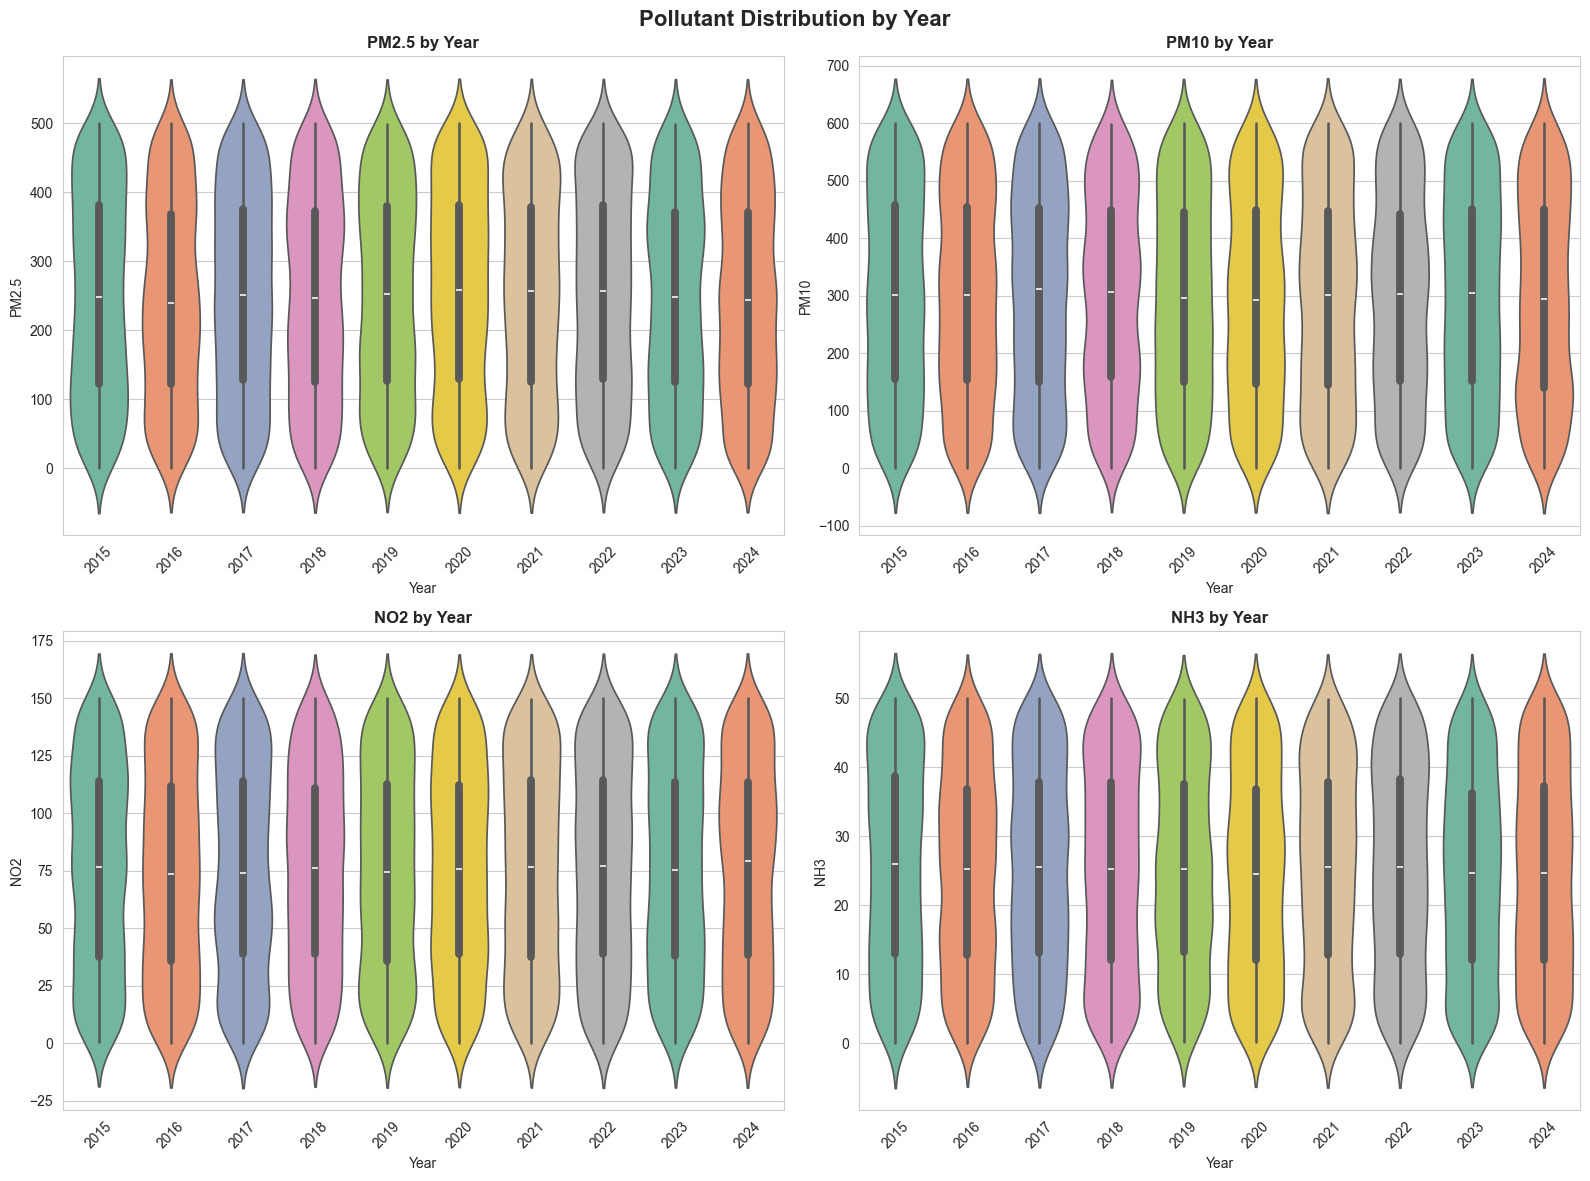

In [20]:
print("\n" + "="*80)
print("Creating Visualization 8: Yearly Distribution Comparison")
print("="*80)

if 'Year' in df.columns and pollutant_cols:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Pollutant Distribution by Year', fontsize=16, fontweight='bold')
    
    for idx, col in enumerate(pollutant_cols[:4]):
        if col in df.columns:
            row, col_pos = idx // 2, idx % 2
            sns.violinplot(data=df, x='Year', y=col, ax=axes[row, col_pos], palette='Set2')
            axes[row, col_pos].set_title(f'{col} by Year', fontweight='bold')
            axes[row, col_pos].tick_params(axis='x', rotation=45)
            
    plt.tight_layout()
    plt.savefig('yearly_distributions.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: yearly_distributions.png")
    plt.show()


## 8. INTERACTIVE SCATTER PLOT - PM2.5 vs PM10

In [25]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.6 MB 1.8 MB/s eta 0:00:06
   ---- ----------------------------------- 1.0/9.6 MB 2.1 MB/s eta 0:00:05
   ------ --------------------------------- 1.6/9.6 MB 2.3 MB/s eta 0:00:04
   -------- ------------------------------- 2.1/9.6 MB 2.4 MB/s eta 0:00:04
   ------------ --------------------------- 2.9/9.6 MB 2.6 MB/s eta 0:00:03
   -------------- ------------------------- 3.4/9.6 MB 2.9 MB/s eta 0:00:03
   -------------- ------------------------- 3.4/9.6 MB 2.9 MB/s eta 0:00:03
   -------------- ------------------------- 3.4/9.6 MB 2.9 MB/s eta 0:00:03
   ----------------- ---------------------- 4.2/9.6 MB 2.2 MB/s eta 0:00:03
   -------------------- ------------------- 5.0/9.6 MB 2.3 MB/s eta 0:00:03
   ---------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
print("\n" + "="*80)
print("Creating Visualization 9: Pollutant Relationships")
print("="*80)

pm25_cols = [col for col in pollutant_cols if 'PM2.5' in col or 'PM25' in col]
pm10_cols = [col for col in pollutant_cols if 'PM10' in col and 'PM2.5' not in col]

if pm25_cols and pm10_cols:
    fig = px.scatter(df, x=pm10_cols[0], y=pm25_cols[0], 
                     color='Year' if 'Year' in df.columns else None,
                     title='Relationship between PM10 and PM2.5',
                     labels={pm10_cols[0]: 'PM10 Concentration', pm25_cols[0]: 'PM2.5 Concentration'},
                     opacity=0.6, trendline='ols')
    fig.update_layout(height=600)
    fig.write_html('pm_relationship.html')
    print("✓ Saved: pm_relationship.html")


Creating Visualization 9: Pollutant Relationships
✓ Saved: pm_relationship.html


# SUMMARY

In [29]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated Files:")
print("  📊 temporal_trends.html - Time series of pollutants")
print("  📊 pollutant_distributions.png - Box plots of pollutant distributions")
print("  📊 yearly_trends.html - Average yearly trends")
print("  📊 seasonal_patterns.png - Monthly heatmap")
print("  📊 correlation_matrix.png - Pollutant correlations")
print("  📊 geographic_analysis.html - Top polluted locations")
print("  📊 aqi_distribution.html - AQI category breakdown")
print("  📊 yearly_distributions.png - Violin plots by year")
print("  📊 pm_relationship.html - PM2.5 vs PM10 scatter plot")
print("\n" + "="*80)


ANALYSIS COMPLETE!

Generated Files:
  📊 temporal_trends.html - Time series of pollutants
  📊 pollutant_distributions.png - Box plots of pollutant distributions
  📊 yearly_trends.html - Average yearly trends
  📊 seasonal_patterns.png - Monthly heatmap
  📊 correlation_matrix.png - Pollutant correlations
  📊 geographic_analysis.html - Top polluted locations
  📊 aqi_distribution.html - AQI category breakdown
  📊 yearly_distributions.png - Violin plots by year
  📊 pm_relationship.html - PM2.5 vs PM10 scatter plot

